# SegNet Training on Colab

This notebook sets up the environment and runs the training script for SegNet.

# Getting the Data and training files

In [ ]:
# # # 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 2. Unzip the project files
# Assumes you uploaded 'segNet_colab.zip' to the root of your MyDrive
# !unzip -o "/content/drive/MyDrive/segNet/segNet.zip" -d "/content"

## Install Dependencies

In [ ]:
# 3. Install dependencies
!pip install torch torchvision pillow numpy

# Training the Model

In [ ]:
# 4. Run the training script
%cd /content/drive/MyDrive/segNet
!python main.py

/content/drive/MyDrive/segNet
Using device: cuda
Initializing Datasets with Augmentation...
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Calculating class weights (Median Frequency Balancing)...
Calculated Weights: tensor([ 0.2663,  0.1929,  4.5642,  0.1417,  1.0000,  0.4614,  3.8248,  3.9814,
         0.7648,  7.0182, 15.3816])
Using manual paper weights: tensor([ 0.2663,  0.1929,  4.5642,  0.1417,  1.0000,  0.4614,  3.8248,  3.9814,
         0.7648,  7.0182, 15.3816], device='cuda:0')
Starting training...at 1764346995.5996559
Epoch [1/100], Step [1/92], Loss: 2.5202
Epoch [1/100], 

# Making Inference

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import random

%cd /content/drive/MyDrive/segNet

# Import your classes
from main import SegNet, CamVidDataset

# --- CONFIGURATION ---
MODEL_PATH = 'segnet_final.pth'
TXT_TEST = './CamVid/test.txt'  # Use test.txt (or val.txt if you prefer)
ROOT_DIR = '.'
NUM_IMAGES_TO_SHOW = 6  # We want 6 images

# Class Colors (Same as main.py)
class_colors = [
    (128, 128, 128), (128, 0, 0), (192, 192, 128), (128, 64, 128),
    (0, 0, 192), (128, 128, 0), (192, 128, 128), (64, 64, 128),
    (64, 0, 128), (64, 64, 0), (0, 128, 192)
]

/content/drive/MyDrive/segNet


Running inference on cpu...


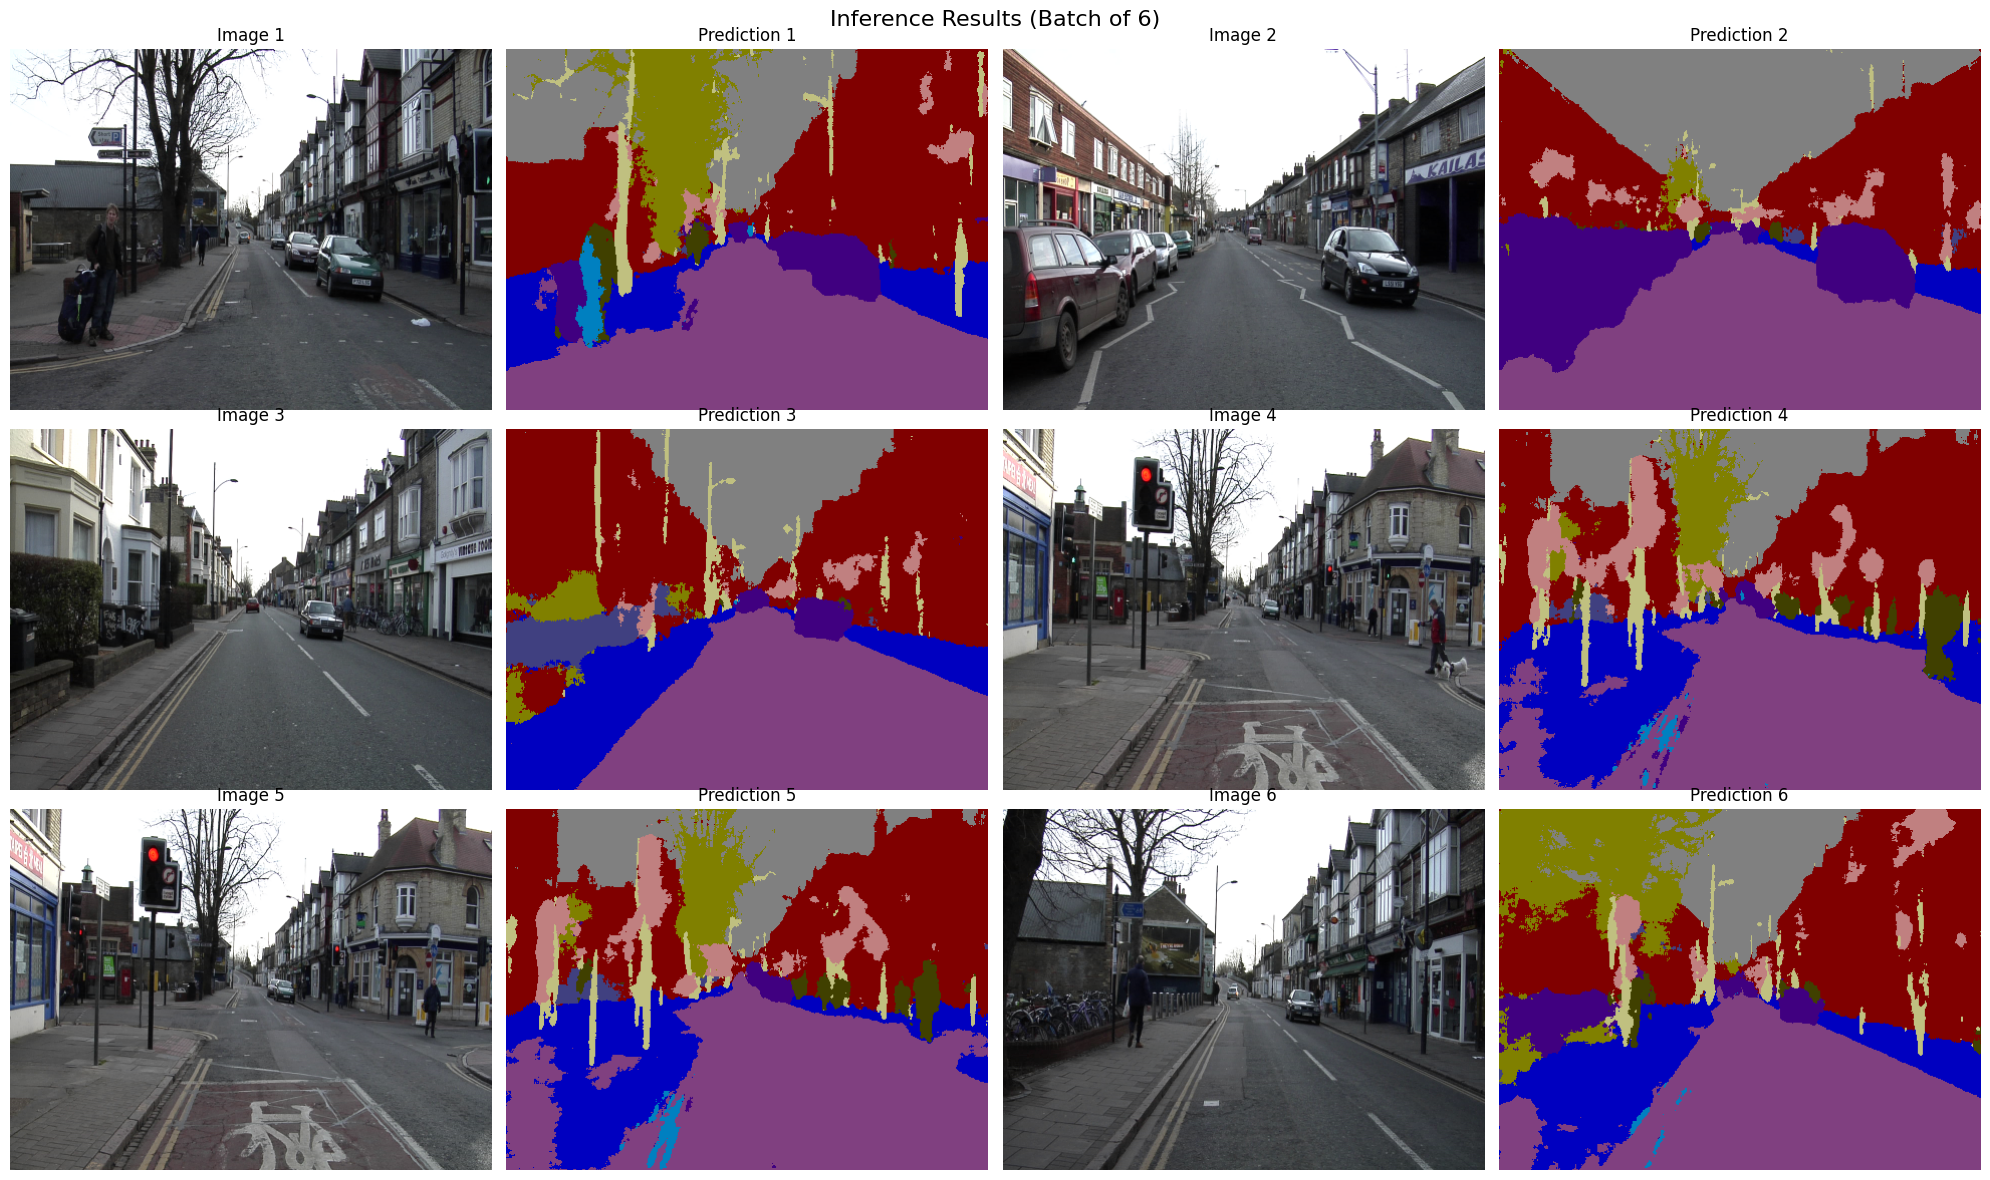

Saved visualization to 'inference_grid.png'


In [ ]:
def decode_segmap(image_tensor, nc=11):
    """
    Decodes the prediction tensor (indices) back to an RGB image.
    """
    label_colors = np.array(class_colors)
    r = np.zeros_like(image_tensor).astype(np.uint8)
    g = np.zeros_like(image_tensor).astype(np.uint8)
    b = np.zeros_like(image_tensor).astype(np.uint8)

    for l in range(0, nc):
        idx = image_tensor == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]

    rgb = np.stack([r, g, b], axis=2)
    return rgb

def visualize_results():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Running inference on {device}...")

    # 1. Load Data
    # We create a loader with batch_size=6 to get exactly 6 images at once
    # Correcting the arguments for CamVidDataset to point to image and mask directories
    test_dataset = CamVidDataset(TXT_TEST, ROOT_DIR)

    # Check if we have enough images
    if len(test_dataset) < 6:
        print(f"Warning: Dataset only has {len(test_dataset)} images.")
        batch_size = len(test_dataset)
    else:
        batch_size = 6

    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

    # 2. Load Model
    model = SegNet(input_channels=3, output_classes=11).to(device)
    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    model.eval()

    # 3. Get one batch
    data_iter = iter(test_loader)
    images, masks = next(data_iter)

    images = images.to(device)

    # 4. Inference
    with torch.no_grad():
        outputs = model(images)
        # Get predictions (indices 0-10)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()

    # Move inputs back to CPU for plotting
    # We also need to un-normalize the images to display them correctly
    images = images.cpu()

    # Inverse Normalization parameters (from main.py)
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    # 5. Setup Matplotlib Grid
    # We need 3 rows and 4 columns to fit 6 pairs (Image + Prediction)
    rows = 3
    cols = 4
    fig, axes = plt.subplots(rows, cols, figsize=(20, 12))
    fig.suptitle(f'Inference Results (Batch of {batch_size})', fontsize=16)

    # Flatten axes for easy iteration, or handle indexing manually
    # We will fill them pair by pair

    for i in range(batch_size):
        # Calculate grid position
        # i=0 -> row 0, cols 0,1
        # i=1 -> row 0, cols 2,3
        # i=2 -> row 1, cols 0,1 ...
        row = i // 2
        col_start = (i % 2) * 2

        # --- INPUT IMAGE ---
        ax_img = axes[row, col_start]
        # Un-normalize
        img_vis = images[i] * std + mean
        # Convert (C, H, W) -> (H, W, C) and clamp to 0-1
        img_vis = img_vis.permute(1, 2, 0).numpy()
        img_vis = np.clip(img_vis, 0, 1)

        ax_img.imshow(img_vis)
        ax_img.set_title(f"Image {i+1}")
        ax_img.axis('off')

        # --- PREDICTION ---
        ax_pred = axes[row, col_start + 1]
        pred_rgb = decode_segmap(preds[i])

        ax_pred.imshow(pred_rgb)
        ax_pred.set_title(f"Prediction {i+1}")
        ax_pred.axis('off')

    plt.tight_layout()
    plt.savefig('inference_grid.png')
    plt.show()
    print("Saved visualization to 'inference_grid.png'")

if __name__ == "__main__":
    visualize_results()

# EVALUATION

In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
from main import SegNet, CamVidDataset  # Import from your main script

%cd /content/segNet

# --- CONFIGURATION ---
MODEL_PATH = 'segnet_final.pth'
TXT_TEST = './CamVid/test.txt'  # Correct file path for test data list
ROOT_DIR = '.' # Root directory where CamVid folder resides
BATCH_SIZE = 4
NUM_CLASSES = 11

def compute_iou(model, loader, device):
    model.eval()

    # Confusion matrix to store counts: Rows=GT, Cols=Pred
    confusion_matrix = np.zeros((NUM_CLASSES, NUM_CLASSES))

    print("Starting evaluation on Test Set...")

    with torch.no_grad():
        for i, (images, masks) in enumerate(loader):
            images = images.to(device)
            masks = masks.to(device) # Shape: [Batch, H, W]

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1) # Shape: [Batch, H, W]

            # Move to CPU for numpy calculation
            preds = preds.flatten().cpu().numpy()
            masks = masks.flatten().cpu().numpy()

            # Filter out "Void" class (11 or -100)
            # We only care about pixels where the Ground Truth is a valid class (0-10)
            valid_indices = np.where((masks >= 0) & (masks < NUM_CLASSES))
            preds_flat = preds[valid_indices]
            masks_flat = masks[valid_indices]

            # Update Confusion Matrix
            # This is a fast trick to update the matrix
            # bincount calculates occurrences of each (label, pred) pair
            n = NUM_CLASSES
            indices = masks_flat * n + preds_flat
            count = np.bincount(indices.astype(np.int64), minlength=n**2)
            confusion_matrix += count.reshape(n, n)

            if (i+1) % 10 == 0:
                print(f"Processed {i+1} batches...")

    # --- CALCULATE METRICS ---

    # 1. Global Accuracy: Sum of Diagonal / Sum of Total
    # (Correct Pixels) / (Total Pixels)
    global_acc = np.diag(confusion_matrix).sum() / confusion_matrix.sum()

    # 2. Class Accuracy: Diagonal / Sum of Rows
    # (Correct for Class X) / (Total True Pixels of Class X)
    # We use nan_to_num to handle classes that might not appear in the test set
    class_acc = np.diag(confusion_matrix) / confusion_matrix.sum(axis=1)
    mean_class_acc = np.nanmean(class_acc)

    # 3. Mean IoU: Diagonal / (Sum of Rows + Sum of Cols - Diagonal)
    # Intersection / Union
    intersection = np.diag(confusion_matrix)
    union = confusion_matrix.sum(axis=1) + confusion_matrix.sum(axis=0) - intersection
    iou = intersection / union
    mean_iou = np.nanmean(iou)

    return global_acc, mean_class_acc, mean_iou, class_acc, iou

if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Evaluating on {device}")

    # Load Data
    test_dataset = CamVidDataset(TXT_TEST, ROOT_DIR)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

    # Load Model
    model = SegNet(input_channels=3, output_classes=NUM_CLASSES).to(device)
    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))

    # Run Evaluation
    g_acc, c_acc, mIoU, per_class_acc, per_class_iou = compute_iou(model, test_loader, device)

    print("\n" + "="*30)
    print("EVALUATION RESULTS")
    print("="*30)
    print(f"Global Accuracy (G):      {g_acc*100:.2f}%")
    print(f"Class Average Acc (C):    {c_acc*100:.2f}%")
    print(f"Mean IoU (mIoU):          {mIoU*100:.2f}%")
    print("-" * 30)
    print("PER CLASS IoU:")

    class_names = ['Sky', 'Building', 'Pole', 'Road', 'Pavement', 'Tree',
                   'SignSymbol', 'Fence', 'Car', 'Pedestrian', 'Bicyclist']

    for i, name in enumerate(class_names):
        print(f"{name:12s}: {per_class_iou[i]*100:.2f}%")

[Errno 2] No such file or directory: '/content/segNet'
/content/drive/MyDrive/segNet
Evaluating on cpu


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Starting evaluation on Test Set...
Processed 10 batches...
Processed 20 batches...
Processed 30 batches...
Processed 40 batches...
Processed 50 batches...

EVALUATION RESULTS
Global Accuracy (G):      83.61%
Class Average Acc (C):    67.52%
Mean IoU (mIoU):          50.69%
------------------------------
PER CLASS IoU:
Sky         : 90.45%
Building    : 67.40%
Pole        : 19.86%
Road        : 88.08%
Pavement    : 64.37%
Tree        : 64.79%
SignSymbol  : 16.56%
Fence       : 24.60%
Car         : 67.03%
Pedestrian  : 29.01%
Bicyclist   : 25.39%
